# Titanic Challenge for kaggle.com

Attempt number 2.

Our previous attempt has a score of 0.78947. We did not do any feature engineering, and simply run RandomForest classifier tuned with RandomSearchCV,

After reading around, especially https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner, I am inspired to try a few ways to improve the features and model.



## 1) Import libraries

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 2) Import train and test dataset

In [2]:
# data will be used for training and validation
# test will be used for final evaluation
data = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"O'Sullivan, Miss. Bridget Mary",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:
test.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Loring, Mr. Joseph Holland",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


## 3) Initial Data Analysis

### our data
the only difference between train and test dataset is that test dataset has **no** "Survived" label, since that's what we are trying to predict.

In [5]:
print("train dataset has " + str(len(data)) + " passengers")
print("test dataset has " + str(len(test)) + " passengers")

train dataset has 891 passengers
test dataset has 418 passengers


In [6]:
# exploring our feature data types
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
# see how many feature and label data are missing for both train and test
pd.DataFrame({"train": data.isna().sum(),
              "test": test.isna().sum()})

,train,test
Age,177,86.0
Cabin,687,327.0
Embarked,2,0.0
Fare,0,1.0
Name,0,0.0
Parch,0,0.0
PassengerId,0,0.0
Pclass,0,0.0
Sex,0,0.0
SibSp,0,0.0


### Data Summary 

1. Raw features: 

  * Pclass, 
  * Name, 
  * Sex, 
  * Age, 
  * Sibsp (no. of siblings), 
  * Parch (no. of parent/child), 
  * Ticket, 
  * Fare, 
  * Cabin, 
  * Embarked

 
2. We are trying to use our features to predict our label - "Survived"

 
3. The only difference between train and test dataset is that test dataset has no "Survived" label, since that's what we are trying to predict.


4. There are 891 dataset in train and 418 in test, which is on the low side.

 
5. Data is relatively complete - with most (77%) missing "Cabin" data, and some (20%) missing "Age", and a handful missing "Embarked" and "Fare".

6. Features Data Type:

  * Numerical: Age (Continuous), Fare (Continuous), SibSp (Discrete), Parch (Discrete)
  * Categorical: Survived, Sex, Embarked, Pclass, Ticket, Cabin

## 4) Feature Analysis

We want to go through each feature to get a sense of the data and form some baseline hypothesis

### Sex Feature
We want to see if there is a difference in survival rate between sexes

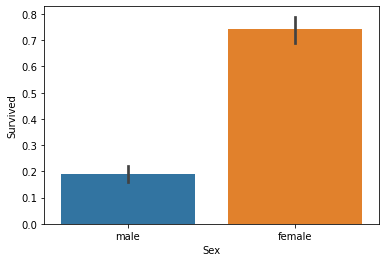

In [8]:
sns.barplot(x="Sex", y="Survived", data=data);

In [9]:
print("Percentage of females who survived:", str(round(data["Survived"][data["Sex"] == 'female'].value_counts(normalize = True)[1]*100, 2)),"%")

print("Percentage of males who survived:", str(round(data["Survived"][data["Sex"] == 'male'].value_counts(normalize = True)[1]*100, 2)),"%")

Percentage of females who survived: 74.2 %
Percentage of males who survived: 18.89 %


"Sex" appears to be an important feature. Female has a significantly higher rate of survival.

### Age Feature

In [10]:
senior = data["Age"][data["Age"] > 60].count()
adult = data["Age"][data["Age"] <= 60][data["Age"] > 40].count()
youngadult = data["Age"][data["Age"] <= 40][data["Age"] > 20].count()
teenager = data["Age"][data["Age"] <= 20][data["Age"] > 12].count()
child = data["Age"][data["Age"] <= 12][data["Age"] > 4].count()
toddler = data["Age"][data["Age"] <= 4][data["Age"] > 1].count()
baby = data["Age"][data["Age"] <= 1][data["Age"] >= 0].count()
missing = data["Age"].isna().sum()
total = senior+adult+youngadult+teenager+child+toddler+baby+missing

print("Passengers by Age Group in train set")
print("senior:", senior)
print("adult:", adult)
print("youngadult:", youngadult)
print("teenager:", teenager)
print("child:", child)
print("toddler:", toddler)
print("baby:", baby)
print("missing:", missing)
print("total:", total)


Passengers by Age Group in train set
senior: 22
adult: 128
youngadult: 385
teenager: 110
child: 29
toddler: 26
baby: 14
missing: 177
total: 891


In [11]:
print("Percentage of senior who survived:", str(round(data["Survived"][data["Age"] > 60].value_counts(normalize = True)[1]*100, 2)),"%")
print("Percentage of adult who survived:", str(round(data["Survived"][data["Age"] <= 60][data["Age"] > 40].value_counts(normalize = True)[1]*100, 2)),"%")
print("Percentage of youngadult who survived:", str(round(data["Survived"][data["Age"] <= 40][data["Age"] > 20].value_counts(normalize = True)[1]*100, 2)),"%")
print("Percentage of teen who survived:", str(round(data["Survived"][data["Age"] <= 20][data["Age"] > 12].value_counts(normalize = True)[1]*100, 2)),"%")
print("Percentage of child who survived:", str(round(data["Survived"][data["Age"] <= 12][data["Age"] > 4].value_counts(normalize = True)[1]*100, 2)),"%")
print("Percentage of toddler who survived:", str(round(data["Survived"][data["Age"] <= 4][data["Age"] > 1].value_counts(normalize = True)[1]*100, 2)),"%")
print("Percentage of baby who survived:", str(round(data["Survived"][data["Age"] <= 1][data["Age"] > 0].value_counts(normalize = True)[1]*100, 2)),"%")
print("Percentage of age-missing who survived:", str(round(data["Survived"][data["Age"].isna()].value_counts(normalize = True)[1]*100, 2)),"%")


Percentage of senior who survived: 22.73 %
Percentage of adult who survived: 39.06 %
Percentage of youngadult who survived: 39.74 %
Percentage of teen who survived: 38.18 %
Percentage of child who survived: 44.83 %
Percentage of toddler who survived: 57.69 %
Percentage of baby who survived: 85.71 %
Percentage of age-missing who survived: 29.38 %


A few things to note:
1. younger passenger has a higher rate of survival - which makes sense since younger passengers might be prioritised in rescue boat
2. those with age missing has lower survival rate than other age group except for senior. Perhaps we can put them in a category on their own.

### Pclass feature
Pclass refers to the passenger class - 1,2,3 with 1 being the highest.

Percentage of Pclass = 1 who survived: 62.96296296296296
Percentage of Pclass = 2 who survived: 47.28260869565217
Percentage of Pclass = 3 who survived: 24.236252545824847


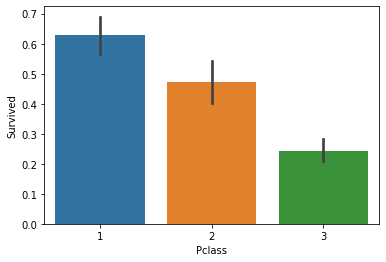

In [12]:

sns.barplot(x="Pclass", y="Survived", data=data)

#print percentage of people by Pclass that survived
print("Percentage of Pclass = 1 who survived:", data["Survived"][data["Pclass"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 2 who survived:", data["Survived"][data["Pclass"] == 2].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 3 who survived:", data["Survived"][data["Pclass"] == 3].value_counts(normalize = True)[1]*100)

### Fare feature
We can test if passengers paying higher fare has higher rate of survival.
We can also see if it makes sense to group fare into different categories; it is now a continuous variable

In [13]:
data["Fare"].min(), data["Fare"].max(), data["Fare"].mean()

(0.0, 512.3292, 32.2042079685746)

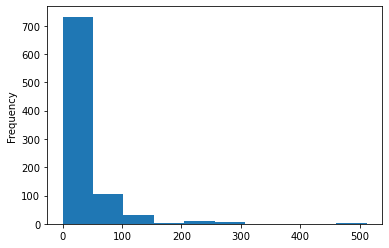

In [14]:
data["Fare"].plot.hist();

In [15]:
# grouping fare
high_fare = data["Fare"][data["Fare"] > 200].count()
mid_fare = data["Fare"][data["Fare"] <= 200][data["Fare"] > 50].count()
low_fare = data["Fare"][data["Fare"] <= 50][data["Fare"] > 25].count()
dirt_fare = data["Fare"][data["Fare"] <= 25].count()

# print("high: ", high_fare)
high_fare, mid_fare, low_fare, dirt_fare



(20, 140, 174, 557)

In [16]:
# testing hypothesis: percentage of high-fare group who survived
print("Percentage of high-fare who survived:", data["Survived"][data["Fare"] > 200].value_counts(normalize = True)[1]*100)
print("Percentage of mid-fare who survived:", data["Survived"][data["Fare"] <= 200][data["Fare"] > 50].value_counts(normalize = True)[1]*100)
print("Percentage of low-fare who survived:", data["Survived"][data["Fare"] <= 50][data["Fare"] > 25].value_counts(normalize = True)[1]*100)
print("Percentage of dirt-fare who survived:", data["Survived"][data["Fare"] <= 25].value_counts(normalize = True)[1]*100)

Percentage of high-fare who survived: 70.0
Percentage of mid-fare who survived: 67.85714285714286
Percentage of low-fare who survived: 41.95402298850575
Percentage of dirt-fare who survived: 28.725314183123878


Higher-fared passengers have significantly higher survival rate

### SibSp features
Number of siblings. Not sure what hypothesis we can form out of this, lets explore!

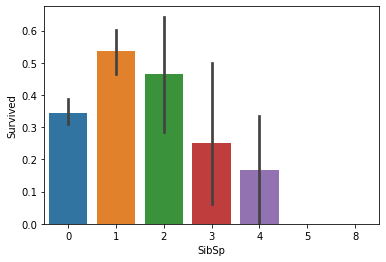

In [17]:
# survival rate by no. of siblings
sns.barplot(x="SibSp", y="Survived", data=data);

There's a marked difference between those with 1-2 siblings vs those with more or 0 sibling.

Perhaps when a family has many siblings, someone needed to sacrifice.

### Parch feature
No. of Parent/Child


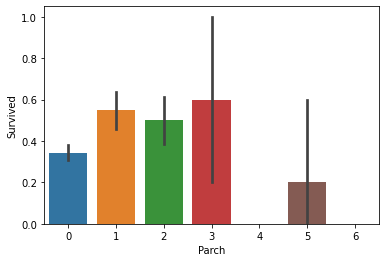

In [18]:
sns.barplot(x="Parch", y="Survived", data=data);

#### Cabin feature

Cabin has the most missing data. And its data might overlap with "Pclass"

In [19]:
has_cabin = data["Cabin"][data["Cabin"] != None].count()
no_cabin = data["Cabin"].isna().sum()
has_cabin, no_cabin

(204, 687)

In [20]:
# explore survival rate of those with recorded cabins vs without

print("Percentage of has_cabin who survived:", data["Survived"][data["Cabin"] != None].value_counts(normalize = True)[1]*100)

print("Percentage of no_cabin who survived:", data["Survived"][data["Cabin"].isna()].value_counts(normalize = True)[1]*100)

Percentage of has_cabin who survived: 38.38383838383838
Percentage of no_cabin who survived: 29.985443959243085


There seems to be a difference between those with recorded cabins and those without. We can consider grouping them into boolean of 1 and 0.

In [21]:
# explore survival rate by cabin (A to G)
# we are filling up missing with "Z" since str.contains doesn't work on missing value
data["Cabin"].fillna("Z", inplace=True)

In [22]:
cabin_class = ["A", "B", "C", "D", "E", "F", "G", "Z"]

for cabin in cabin_class:
    print("% of cabin class", cabin, "who survived: ", 
          str(round(data["Survived"][data["Cabin"].str.contains(cabin)].value_counts(normalize = True)[1]*100)), "%",
          "out of ", data["Cabin"].str.contains(cabin).sum(), "passengers")

% of cabin class A who survived:  47.0 % out of  15 passengers
% of cabin class B who survived:  74.0 % out of  47 passengers
% of cabin class C who survived:  59.0 % out of  59 passengers
% of cabin class D who survived:  76.0 % out of  33 passengers
% of cabin class E who survived:  76.0 % out of  33 passengers
% of cabin class F who survived:  62.0 % out of  13 passengers
% of cabin class G who survived:  29.0 % out of  7 passengers
% of cabin class Z who survived:  30.0 % out of  687 passengers


The sample size for each cabin size is pretty small, so it might not make sense to classify based on different classes since it might result in overfitting? So for now, we will stick to classifying by has_cabin and no_cabin.

### Embarked feature
Embarked means where did the passenger come on board - there are 3 categories: Southampton (S), Cherbourg (C), and Queenstown (Q).



In [23]:
print("Number of people embarking in Southampton (S):", data["Embarked"][data["Embarked"] == "S"].count())

print("Number of people embarking in Cherbourg (C):", data["Embarked"][data["Embarked"] == "C"].count())

print("Number of people embarking in Queenstown (Q):", data["Embarked"][data["Embarked"] == "Q"].count())

Number of people embarking in Southampton (S): 644
Number of people embarking in Cherbourg (C): 168
Number of people embarking in Queenstown (Q): 77


since the majority of people embarked from S, we will fill up missing value with S as well

In [24]:
print("Percentage of S who survived:", data["Survived"][data["Embarked"] == "S"].value_counts(normalize = True)[1]*100)
print("Percentage of C who survived:", data["Survived"][data["Embarked"] == "C"].value_counts(normalize = True)[1]*100)
print("Percentage of Q who survived:", data["Survived"][data["Embarked"] == "Q"].value_counts(normalize = True)[1]*100)

Percentage of S who survived: 33.69565217391305
Percentage of C who survived: 55.35714285714286
Percentage of Q who survived: 38.961038961038966


### Name feature

On first glance, name should not matter in a passenger's survival rate.

However, our name data contains titles such as "Countess, Rev, Don, Master" should might be a signifer for social status.

In [25]:
#create a combined group of both datasets
combine = [data, test]

#extract a title for each Name in the train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(data['Title'], data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [26]:
# test our hypothesis if certain titles have higher survival rate
# note that sample size is limited, so we will only be testing a few

print("Master", data["Survived"][data["Title"] == "Master"].value_counts(normalize = True)[1]*100)
print("Miss", data["Survived"][data["Title"] == "Miss"].value_counts(normalize = True)[1]*100)
print("Mrs", data["Survived"][data["Title"] == "Mrs"].value_counts(normalize = True)[1]*100)
print("Dr", data["Survived"][data["Title"] == "Dr"].value_counts(normalize = True)[1]*100)

Master 57.49999999999999
Miss 69.78021978021978
Mrs 79.2
Dr 42.857142857142854


From a quick look, it seems that female titles have higher survival rate. 

Since this information is already captured by "Sex" feature, we will be dropping title and name.

## 5) Feature Engineering

Feature Engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive model

Now that we have explored our data, we need to prepare our data for analysis:
1. Decide what features we want to drop / add
2. Decide what features we want to make changes: e.g. grouping of cabin, fare, age 
3. fill missing values for Cabin, Age, Embarked, Fare
4. change non-numerical values to numerical values

In [27]:
#get a list of the features within the dataset
print(data.columns)
print(test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title'],
      dtype='object')


### Splitting our data into X and y 

* y is our label - "Survived"
* X is our features

In [28]:
# Split into X and y
X = data.drop("Survived", axis=1)
y = data["Survived"]

### Build data transform pipeline
We want to build a function that can transform our data - so that we can use the same function to apply to train, validation, and eventually test set,

In [29]:
# writing our function

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def transform_data(data):
    # create new feature: HasCabin
    data["Cabin"].fillna("Z", inplace=True) # we previously filled missing with Z on train, but haven't done for test
    data["HasCabin"] = data["Cabin"].str.contains("Z").astype('int')
    
    # create new feature: AgeGroup
    data["Age"] = data["Age"].fillna(-0.5)
    bins = [-1, 0, 1, 4, 12, 20, 40, 60, np.inf]
    labels = ['AgeMissing', 'Baby', 'Toddler', 'Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
    data['AgeGroup'] = pd.cut(data["Age"], bins, labels = labels)    

    # create new feature: FareGroup
    data["Fare"] = data["Fare"].fillna(-0.5)
    bins_2 = [-1, 0, 25, 50, 200, np.inf]
    labels_2 = ['FareMissing', 'DirtFare', 'LowFare', 'MidFare', 'HighFare']
    data['FareGroup'] = pd.cut(data["Fare"], bins_2, labels = labels_2)     
    
    # remove "PassengerId", "Name", "Ticket", "Title", "Cabin", "Age", "Fare"
    data = data.drop("PassengerId", axis=1)
    data = data.drop("Name", axis=1)
    data = data.drop("Ticket", axis=1)
    data = data.drop("Title", axis=1)
    data = data.drop("Cabin", axis=1)
    data = data.drop("Age", axis=1)
    data = data.drop("Fare", axis=1)                                                            
    
    # fill na with pandas
    # HasCabin, AgeGroup, and FareGroup already filled above, so only need to fill Embarked
    data["Embarked"].fillna(data["Embarked"].mode()[0], inplace=True)
    
    # transform "Sex", "Embark", "AgeGroup", "FareGroup", "Pclass", "HasCabin"
    # One Hot Encoding transforms categories into different feature columns of 1 and 0
    # note even though "Pclass" data is in numbers (1,2,3), they are Categorical features (instead of numerical like Age) hence we need to encode it
    one_hot = OneHotEncoder()
    transformer = ColumnTransformer([("one_hot",
                                      one_hot,
                                      ["Sex", "Embarked", "AgeGroup", "FareGroup", "Pclass", "HasCabin"])],
                                    remainder="passthrough")
    data = transformer.fit_transform(data)
    
    return data

### Transform on X to get X_tf

In [30]:
# applying our function to transform X_train

X_tf = transform_data(X)
pd.DataFrame(X_tf)
# note this converts to numpy array, and not pd

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
887,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
888,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0
889,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Lets see our transformed data is done correctly.

From above, our transformed data has 25 columns (starting from 0).

It should have:

* 1x "SibSp",
* 1x "Parch",
* 2x "Sex", 
* 3x "Embarked", 
* 8x "AgeGroup", 
* 5x "FareGroup", 
* 3x "Pclass",
* 2x "HasCabin"

In [31]:
# number of columns we should have
1+1+2+3+8+5+3+2

25

In [32]:
# check that number of rows is intact
len(X_tf), len(X)

(891, 891)

In [33]:
# check if any missing value
pd.DataFrame(X_tf).isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
dtype: int64

### Splitting data train and validation

In general, it's good practice to split data into training and validation set **before** applying any feature engineering.

But since our sample size is small, we decide to split after feature engineering is applied.

In [34]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split
np.random.seed(17)
X_train, X_val, y_train, y_val = train_test_split(X_tf, y, test_size=0.2)

In [35]:
# confirm splitting is done right
len(X_train), len(X_val), len(y_train), len(y_val)

(712, 179, 712, 179)

## 6) Modeling

We're going to try 4 different machine learning models that are used for Classification problem:

1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier
4. Gradient Boosting Classifier
5. Support Vector Machines
6. Stochastic Gradient Descent
7. Decision Tree

We are using training data (X_train, y_train) for **fitting / training** the model 

Then, we use validation data (X_val, y_val) to **validate and evaluate** how accuracy our model is.
* we use default `score` method of each model to get accuracy score
* in essense, what `score` method does is it predicts on X_val data and produces a y_prediction data. 
* and then, it compares y_prediction (Machine's guess) with y_val (actual answer) to see how accurate is the prediction

In [36]:
# Creating a function to fit and score across the models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Gradient Boosting": GradientBoostingClassifier(),
          "SVC": SVC(),
          "SGD": SGDClassifier(),
          "Decision Tree": DecisionTreeClassifier()}


def fit_and_score(models, X_train, X_val, y_train, y_val):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    """
    # Set random seed
    np.random.seed(17)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_val, y_val)
    return model_scores


In [37]:
# Executing our function, and we will see the "accuracy" score (using default scoring method of each model)
fit_and_score(models=models,
              X_train=X_train,
              X_val=X_val,
              y_train=y_train,
              y_val=y_val)

{'Logistic Regression': 0.770949720670391,
 'KNN': 0.7318435754189944,
 'Random Forest': 0.7821229050279329,
 'Gradient Boosting': 0.7653631284916201,
 'SVC': 0.7877094972067039,
 'SGD': 0.770949720670391,
 'Decision Tree': 0.776536312849162}

## 7) Evaluation 

### Additional Metrics to evaluate different models

We want to have more metrics in addition to "accuracy" to give us better assess performance of each model.

For now, we will evaluate our 3 most accurate models - Random Forest, SVC, Decision Tree

In [38]:
# creating a evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_preds(y_true, y_preds):
    """
    perform evaluation comparison on y_true labels vs y_preds labels
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                    "precision": round(precision, 2),
                    "recall": round(recall, 2),
                    "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    return metric_dict

In [39]:
# RandomForest

np.random.seed(19)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_preds = rf.predict(X_val)  # ML's prediction using X_val

# evaluate using our evaluation function on validation set
rf_metrics = evaluate_preds(y_val, y_preds)  # compares y_preds with y_val/y_true
rf_metrics

Acc: 77.09%
Precision: 0.72
Recall: 0.73
F1 score: 0.72


{'accuracy': 0.77, 'precision': 0.72, 'recall': 0.73, 'f1': 0.72}

In [40]:
# SVC

np.random.seed(19)
svc = SVC()
svc.fit(X_train, y_train)
y_preds = svc.predict(X_val)  # ML's prediction using X_val

# evaluate using our evaluation function on validation set
svc_metrics = evaluate_preds(y_val, y_preds)  # compares y_preds with y_val/y_true
svc_metrics

Acc: 78.77%
Precision: 0.79
Recall: 0.66
F1 score: 0.72


{'accuracy': 0.79, 'precision': 0.79, 'recall': 0.66, 'f1': 0.72}

In [41]:
# Decision Tree

np.random.seed(19)
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_preds = decision_tree.predict(X_val)  # ML's prediction using X_val

# evaluate using our evaluation function on validation set
decision_tree_metrics = evaluate_preds(y_val, y_preds)  # compares y_preds with y_val/y_true
decision_tree_metrics


Acc: 77.09%
Precision: 0.73
Recall: 0.70
F1 score: 0.71


{'accuracy': 0.77, 'precision': 0.73, 'recall': 0.7, 'f1': 0.71}

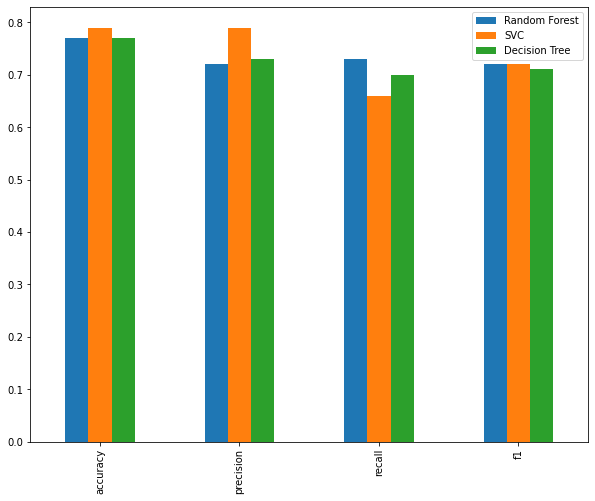

In [42]:
# Lets compare our different models with new metrics

compare_metrics = pd.DataFrame({"Random Forest": rf_metrics,
                                "SVC": svc_metrics,
                                "Decision Tree": decision_tree_metrics})
compare_metrics.plot.bar(figsize=(10,8));

### Result:

There is a whole science in making sense of the different metrics.


1)

In general, if there is **class imbalance**, precision and recall are more important than accuracy.

Class imbalance means e.g. in "Sex", if our data has 95% male and 5% female, it makes it difficult for machine learning to predict accurately especially for minority class.

In our data, due to our small sample size, there are quite a few features that have imbalanced classes, e.g. Pclass, FareGroup, etc.


2)

If false positive predictions are worse than false negatives (depend on the project), aim for higher precision. If false negative predictions are worse than false positives, aim for higher recall.

For us, we are no preference on false positive or false negative, since we are not predicting if a patient has heart disease, for instance.


3)
In our case, both Random Forest and SVC are very close in metrics.

* they are equal in F1-score. F1-score is a combination of precision and recall.
* SVC has higher accuracy.

Thus, we will be using SVC for further tuning.

## 8) Tuning Hyperparameters of our Model

Tuning hyperparameters helps to optimise the performance of a model. 

Hyperparameters are parameters that are external to our model's learning that can potentially helps improve its ability to predict.

We will be using RandomSearchCV and GridSearchCV for tuning.

In [43]:
# check available hyperparameters for SVC
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [44]:
# tuning hyperparameters by RandomSearchCV

from sklearn.model_selection import RandomizedSearchCV
grid = {"kernel": ["linear", "rbf", "poly"],
        "gamma": ["scale", "auto"],
        "degree": [0,1,2,3,4,5,6],
        "class_weight": ["balanced", None],
        "C": [100, 10, 1.0, 0.1, 0.001]}

np.random.seed(17)

svc = SVC()
rs_svc = RandomizedSearchCV(estimator=svc,
                            param_distributions=grid,  # what we defined above
                            n_iter=10, # number of combinations to try
                            cv=5,   # number of cross-validation split
                            verbose=2)
rs_svc.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] kernel=linear, gamma=auto, degree=2, class_weight=balanced, C=0.1 
[CV]  kernel=linear, gamma=auto, degree=2, class_weight=balanced, C=0.1, total=   0.0s
[CV] kernel=linear, gamma=auto, degree=2, class_weight=balanced, C=0.1 
[CV]  kernel=linear, gamma=auto, degree=2, class_weight=balanced, C=0.1, total=   0.0s
[CV] kernel=linear, gamma=auto, degree=2, class_weight=balanced, C=0.1 
[CV]  kernel=linear, gamma=auto, degree=2, class_weight=balanced, C=0.1, total=   0.0s
[CV] kernel=linear, gamma=auto, degree=2, class_weight=balanced, C=0.1 
[CV]  kernel=linear, gamma=auto, degree=2, class_weight=balanced, C=0.1, total=   0.0s
[CV] kernel=linear, gamma=auto, degree=2, class_weight=balanced, C=0.1 
[CV]  kernel=linear, gamma=auto, degree=2, class_weight=balanced, C=0.1, total=   0.0s
[CV] kernel=linear, gamma=scale, degree=1, class_weight=None, C=10 ...
[CV]  kernel=linear, gamma=scale, degree=1, class_weight=None, C=10, tota

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  kernel=linear, gamma=scale, degree=1, class_weight=None, C=10, total=   0.0s
[CV] kernel=linear, gamma=scale, degree=1, class_weight=None, C=10 ...
[CV]  kernel=linear, gamma=scale, degree=1, class_weight=None, C=10, total=   0.0s
[CV] kernel=poly, gamma=auto, degree=4, class_weight=balanced, C=1.0 .
[CV]  kernel=poly, gamma=auto, degree=4, class_weight=balanced, C=1.0, total=   0.0s
[CV] kernel=poly, gamma=auto, degree=4, class_weight=balanced, C=1.0 .
[CV]  kernel=poly, gamma=auto, degree=4, class_weight=balanced, C=1.0, total=   0.0s
[CV] kernel=poly, gamma=auto, degree=4, class_weight=balanced, C=1.0 .
[CV]  kernel=poly, gamma=auto, degree=4, class_weight=balanced, C=1.0, total=   0.0s
[CV] kernel=poly, gamma=auto, degree=4, class_weight=balanced, C=1.0 .
[CV]  kernel=poly, gamma=auto, degree=4, class_weight=balanced, C=1.0, total=   0.0s
[CV] kernel=poly, gamma=auto, degree=4, class_weight=balanced, C=1.0 .
[CV]  kernel=poly, gamma=auto, degree=4, class_weight=balanced, C=1.

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


In [45]:
# checking out best parameters we find from tuning
rs_svc.best_params_

{'kernel': 'linear',
 'gamma': 'scale',
 'degree': 1,
 'class_weight': None,
 'C': 10}

In [46]:
# evaluating our model tuned with RandomSearchCV
rs_y_preds = rs_svc.predict(X_val)

# evaluate predictions
rs_metrics = evaluate_preds(y_val, rs_y_preds)

Acc: 79.33%
Precision: 0.78
Recall: 0.68
F1 score: 0.73


In [47]:
# tuning hyperparameters by GridSearchCV
from sklearn.model_selection import GridSearchCV


grid_2 = {"kernel": ["linear", "rbf"],
        "gamma": ["scale"],
        "degree": [1,2,3],
        "class_weight": [None],
        "C": [100, 10, 1.0]}

np.random.seed(17)

svc = SVC()

# Setup GridSearchCV
gs_svc = GridSearchCV(estimator=svc,
                      param_grid=grid_2,
                      cv=5,
                      verbose=2)

# Fit the GSCV version of clf
gs_svc.fit(X_train, y_train);


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] C=100, class_weight=None, degree=1, gamma=scale, kernel=linear ..


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=100, class_weight=None, degree=1, gamma=scale, kernel=linear, total=   0.3s
[CV] C=100, class_weight=None, degree=1, gamma=scale, kernel=linear ..
[CV]  C=100, class_weight=None, degree=1, gamma=scale, kernel=linear, total=   0.2s
[CV] C=100, class_weight=None, degree=1, gamma=scale, kernel=linear ..


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  C=100, class_weight=None, degree=1, gamma=scale, kernel=linear, total=   0.2s
[CV] C=100, class_weight=None, degree=1, gamma=scale, kernel=linear ..
[CV]  C=100, class_weight=None, degree=1, gamma=scale, kernel=linear, total=   0.2s
[CV] C=100, class_weight=None, degree=1, gamma=scale, kernel=linear ..
[CV]  C=100, class_weight=None, degree=1, gamma=scale, kernel=linear, total=   0.2s
[CV] C=100, class_weight=None, degree=1, gamma=scale, kernel=rbf .....
[CV]  C=100, class_weight=None, degree=1, gamma=scale, kernel=rbf, total=   0.0s
[CV] C=100, class_weight=None, degree=1, gamma=scale, kernel=rbf .....
[CV]  C=100, class_weight=None, degree=1, gamma=scale, kernel=rbf, total=   0.0s
[CV] C=100, class_weight=None, degree=1, gamma=scale, kernel=rbf .....
[CV]  C=100, class_weight=None, degree=1, gamma=scale, kernel=rbf, total=   0.0s
[CV] C=100, class_weight=None, degree=1, gamma=scale, kernel=rbf .....
[CV]  C=100, class_weight=None, degree=1, gamma=scale, kernel=rbf, total=   0.0

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    4.6s finished


In [48]:
gs_svc.best_params_

{'C': 10, 'class_weight': None, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [49]:
# evaluating our model tuned with GridSearchCV
gs_y_preds = gs_svc.predict(X_val)

# evaluate predictions
gs_metrics = evaluate_preds(y_val, gs_y_preds)

Acc: 75.42%
Precision: 0.69
Recall: 0.73
F1 score: 0.71


In [50]:
# Lets compare our different model metrics

compare_metrics = pd.DataFrame({"baseline SVC": svc_metrics,
                                "random search": rs_metrics,
                                "grid search": gs_metrics})
compare_metrics

,baseline SVC,random search,grid search
accuracy,0.79,0.79,0.75
precision,0.79,0.78,0.69
recall,0.66,0.68,0.73
f1,0.72,0.73,0.71


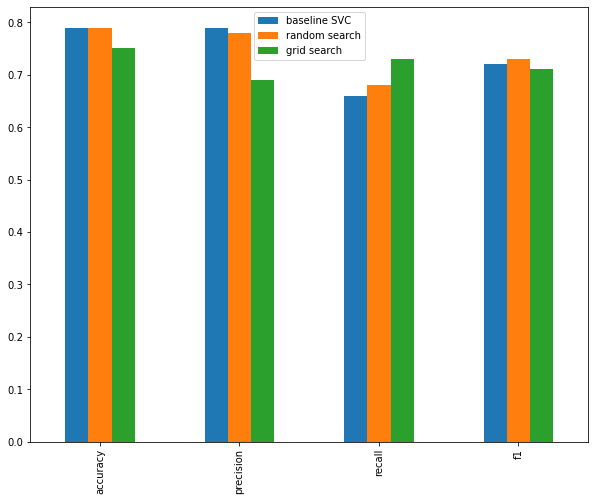

In [51]:
# with bar graph
compare_metrics.plot.bar(figsize=(10,8));

Admittedly, this is my first time tuning SVC model. So I have no idea if I'm doing this right.

The results are close between without tuning and tuning wih RandomSearchCV. We'll be using the latter since it gives a higher F1-score.

## 9) Testing and Submitting

Our final objective is use our best model to predict on test data (with no labels), and upload our prediction to Kaggle to evaluate.

Our model is choice is SVC tuned with RandomSearchCV.

In [52]:
# our raw test data
test.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [53]:
# tranforming test data
test_tf = transform_data(test)
pd.DataFrame(test_tf)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
414,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
415,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
416,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [54]:
# check no missing value
pd.DataFrame(test_tf).isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
dtype: int64

In [55]:
# run our prediction with our rs_svc model

test_preds = rs_svc.predict(test_tf)
pd.DataFrame(test_preds)

,0
0,0
1,1
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [56]:
submission = pd.DataFrame({"PassengerId": test["PassengerId"], 
                          "Survived": test_preds})
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [57]:
# check length

len(submission), len(test)

(418, 418)

In [58]:
submission.to_csv("submission_v2.csv", index=False)

### 10) After thoughts

Our submission has an accuracy score of 0.77033.

Interestingly, our previous submission using RandomForest without doing any feature engineering received a higher score of 0.78947.

So looks like all our deliberate tinkering has actually made a worse model!

Credits to Nadin Tamer for sharing her very beginner-friendly notebook: https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner 